# Волатильность и корреляция фондовых индексов на множественных горизонтах

### Импорт необходимых библиотек

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from arch import arch_model
from sklearn.metrics import mean_squared_error

### Зададим параметры генератора случайных чисел для воспроизводимости

In [3]:
np.random.seed(42)

### 1. Функции загрузки данных и предобработки

In [4]:
def download_price_data(tickers, start='2018-01-01', end=None, interval='1d'):
    """
    Загружает данные через yfinance. Возвращает DataFrame с колонками MultiIndex (Adj Close).
    """
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d')
    data = yf.download(tickers, start=start, end=end, interval=interval, progress=False, threads=True)
    if isinstance(tickers, str) or len(tickers) == 1:
        data = pd.DataFrame(data)
    if ('Adj Close' in data.columns):
        prices = data['Adj Close']
    else:
        prices = data['Close']
    prices = prices.dropna(how='all')
    return prices

def compute_log_returns(prices):
    """
    Возвращает DataFrame лог-доходностей (pct_change -> log(1 + r))
    """
    return np.log(prices / prices.shift(1)).dropna(how='all')

### 2. Агрегация доходностей на разные горизонты
Будем считать горизонты:
- *daily* - исходные ежедневные доходности,
- *weekly* - доходности за неделю,
- *monthly* - доходности за месяц.

In [6]:
def aggregate_returns(log_returns, horizon='weekly'):
    """
    Возвращает агрегированные лог-доходности.
    """
    if horizon == 'daily':
        return log_returns
    if horizon == 'weekly':
        return log_returns.resample('W-FRI').sum().dropna(how='all')
    if horizon == 'monthly':
        return log_returns.resample('M').sum().dropna(how='all')
    raise ValueError("horizon must be 'daily'|'weekly'|'monthly'")

### 3. Реализованная волатильность
Реализованную волатильность будем оценивать следующим способом:
- rolling window realized: скользящая волатильность доходностей на окне `window` (в днях);

In [97]:
def realized_volatility(returns, window=21):
    """
    Скользящее стандартное отклонение по окну `window` (число периодов).
    returns: DataFrame с волатильностями.
    """
    rv = returns.rolling(window=window).std()
    return rv

### 4. Обучение GARCH(1,1) и предсказание условной волатильности
Используем модель GARCH(1,1).  
Будем обучать на дневных лог-доходностях каждого тикера отдельно и получать условную дисперсию (volatility = sqrt(cond_var)).  
Для горизонтов >1 дня - можно:
- масштабировать предсказанную ежедневную волатильность через `sqrt(h)` (приближённо), или
- агрегировать доходности на нужном горизонте и обучить GARCH заново (**целевой вариант**).


In [98]:
def fit_garch_and_predict(returns_series, p=1, q=1, dist='Normal', reindex_to=None):
    """
    Возвращает DataFrame с колонками:
      - 'cond_vol' : условная волатильность на той же частоте (std)
    Если reindex_to задан (index), то результат будет переиндексован с forward-fill.
    """
    # Удаляем NaN
    r = returns_series.dropna()
    # Центрируем (GARCH обычно на demeaned returns, но arch модель содержит constant)
    am = arch_model(r, vol='Garch', p=p, q=q, dist=dist, mean='Constant')
    res = am.fit(disp='off')
    cond_vol = res.conditional_volatility
    cond_var = cond_vol**2
    out = pd.DataFrame({'cond_vol': cond_vol, 'cond_var': cond_var})
    if reindex_to is not None:
        out = out.reindex(reindex_to).ffill()
    return res, out

### 5. Корреляции на разных горизонтах
Корреляцию считаем по агрегированным доходностям (daily/weekly/monthly) - это простая корреляционная матрица.

In [99]:
def horizon_correlations(log_returns, horizons=['daily','weekly','monthly']):
    """
    Возвращает словарь horizon -> correlation matrix (DataFrame).
    """
    res = {}
    for h in horizons:
        agg = aggregate_returns(log_returns, horizon=h)
        corr = agg.corr()
        res[h] = corr
    return res

### 6. Применение описанного подхода на конкретных тикерах

In [100]:
# Параметры
tickers = ['SPY', 'AMZN', 'GOOG'] 
start_date = '2018-01-01'
end_date = None

prices = download_price_data(tickers, start=start_date, end=end_date)
prices = prices.dropna(how='all')
prices.tail()

Ticker,AMZN,GOOG,SPY
Date,,,
2025-10-06,220.899994,251.509995,671.609985
2025-10-07,221.779999,247.130005,669.119995
2025-10-08,225.220001,245.460007,673.109985
2025-10-09,227.740005,242.210007,671.159973
2025-10-10,216.369995,237.490005,653.020020


In [168]:
# Вычисление лог-доходностей (daily)
logret = compute_log_returns(prices)
logret = logret.dropna(how='all')
logret = aggregate_returns(logret, horizon='daily')
logret.head()

Ticker,AMZN,GOOG,SPY
Date,,,
2018-01-03,0.012694,0.016280,0.006305
2018-01-04,0.004466,0.003615,0.004206
2018-01-05,0.016033,0.014466,0.006642
2018-01-08,0.014322,0.004264,0.001827
2018-01-09,0.004665,-0.000614,0.002261


In [169]:
logret.shape

(1954, 3)

In [170]:
# Реализованная волатильность
rv_daily = realized_volatility(logret, window=2)

In [171]:
# Обучаем GARCH(1,1) для каждого тикера на дневных лог-доходностях и предсказываем условную волатильность
garch_results = {}
garch_vols = pd.DataFrame(index=logret.index)
for col in logret.columns:
    res, out = fit_garch_and_predict(logret[col], p=1, q=1, dist='Normal', reindex_to=logret.index)
    garch_results[col] = res
    garch_vols[col] = out['cond_vol']

In [172]:
garch_vols = garch_vols.sort_index()
garch_vols.head()

,AMZN,GOOG,SPY
Date,,,
2018-01-03,0.017612,0.016165,0.010362
2018-01-04,0.017203,0.016438,0.009472
2018-01-05,0.016234,0.015961,0.008581
2018-01-08,0.016659,0.016117,0.007997
2018-01-09,0.016709,0.015708,0.007283


In [173]:
# Сравнение predicted vs realized для одного тикера - пример для SPY
ticker_example = 'SPY'
df_cmp = pd.DataFrame({
    'realized_rv': rv_daily[ticker_example],
    'garch_vol': garch_vols[ticker_example]
}).dropna()

# Считаем RMSE между realized (скользящая std) и predicted (garch)
rmse_garch = np.sqrt(mean_squared_error(df_cmp['realized_rv'], df_cmp['garch_vol']))
print(f'RMSE (GARCH vs realized) для {ticker_example} в случае дневной агрегации: {rmse_garch:.4f}')

RMSE (GARCH vs realized) для SPY в случае дневной агрегации: 0.0076


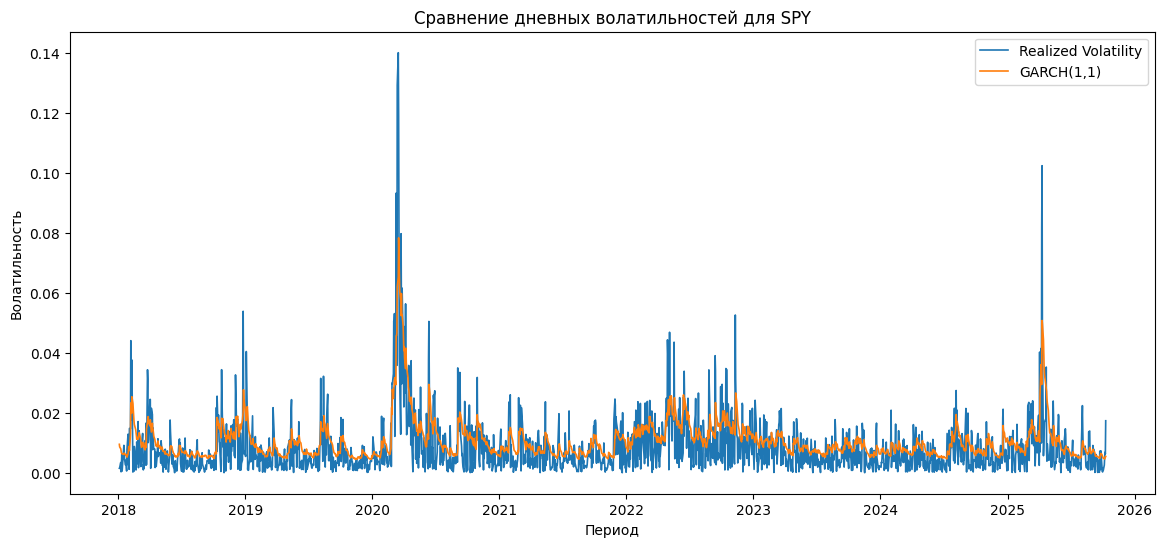

In [174]:
plt.figure(figsize=(14,6))
plt.plot(df_cmp.index, df_cmp['realized_rv'], label='Realized Volatility', linewidth=1.2)
plt.plot(df_cmp.index, df_cmp['garch_vol'], label='GARCH(1,1)', linewidth=1.2)
plt.title(f'Сравнение дневных волатильностей для {ticker_example}')
plt.ylabel('Волатильность')
plt.xlabel('Период')
plt.legend()
plt.show()

**Проделаем ту же работу и построим графики сравнения недельной и месячной волатильностей**

In [175]:
logret_week = aggregate_returns(logret, horizon='weekly')
logret_month = aggregate_returns(logret, horizon='monthly')

In [176]:
rv_week = realized_volatility(logret_week, window=2)  # недельное скользящее окно
rv_month = realized_volatility(logret_month, window=2) # месячное скользящее окно

In [177]:
# Для сравнения: обучим GARCH заново на агрегированных недельных доходностях (пример для одного тикера)
res_week, out_week = fit_garch_and_predict(logret_week[ticker_example], reindex_to=rv_week.index)
res_month, out_month = fit_garch_and_predict(logret_month[ticker_example], reindex_to=rv_month.index)

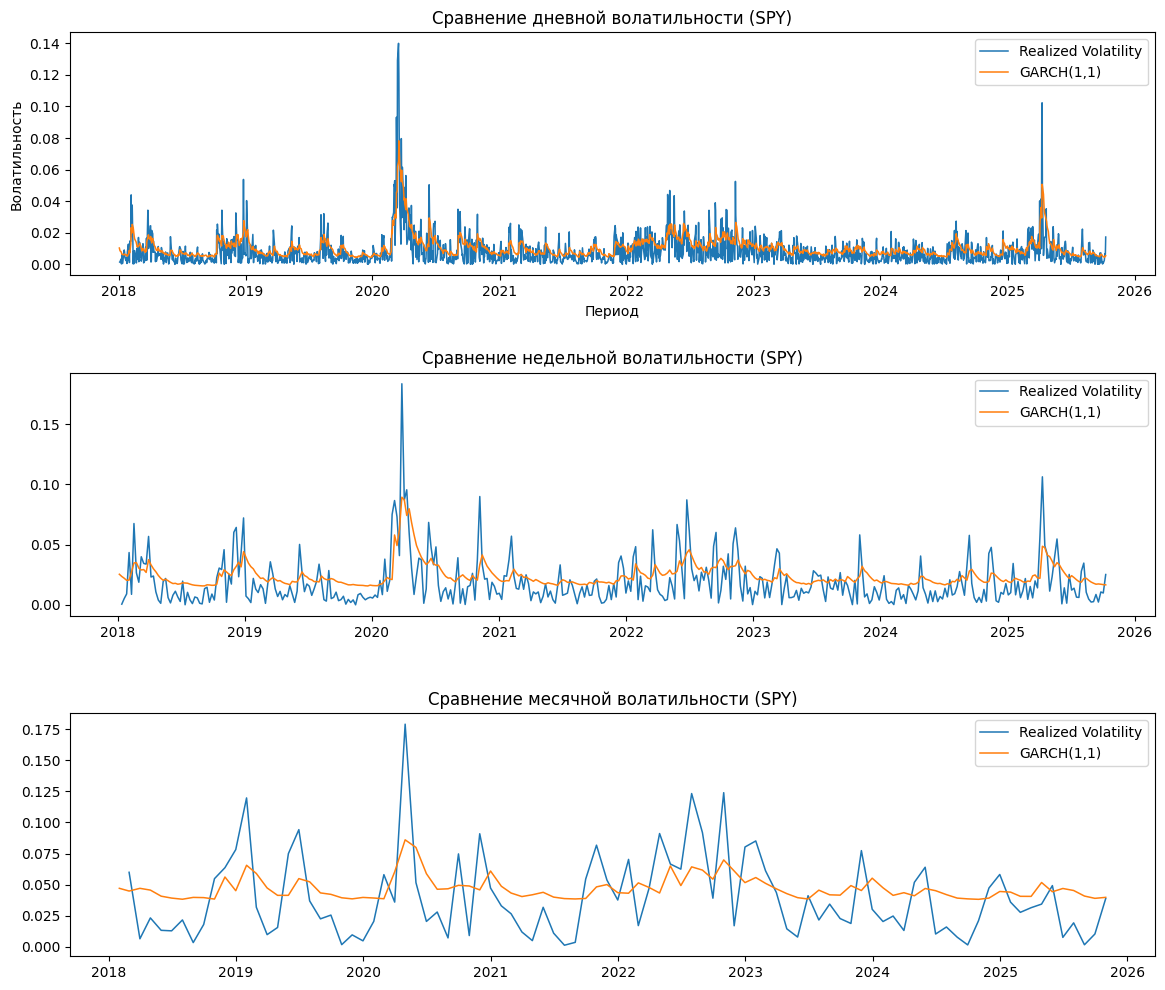

In [178]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharey=False)
plt.subplots_adjust(hspace=0.4)

axes[0].plot(rv_daily.index, rv_daily[ticker_example], label='Realized Volatility', linewidth=1.1)
axes[0].plot(garch_vols.index, garch_vols[ticker_example], label='GARCH(1,1)', linewidth=1.1)
axes[0].set_title(f'Сравнение дневной волатильности ({ticker_example})')
axes[0].set_ylabel('Волатильность')
axes[0].set_xlabel('Период')
axes[0].legend()

axes[1].plot(rv_week.index, rv_week[ticker_example], label='Realized Volatility', linewidth=1.1)
axes[1].plot(out_week.index, out_week['cond_vol'], label='GARCH(1,1)', linewidth=1.1)
axes[1].set_title(f'Сравнение недельной волатильности ({ticker_example})')
axes[0].set_ylabel('Волатильность')
axes[0].set_xlabel('Период')
axes[1].legend()

axes[2].plot(rv_month.index, rv_month[ticker_example], label='Realized Volatility', linewidth=1.1)
axes[2].plot(out_month.index, out_month['cond_vol'], label='GARCH(1,1)', linewidth=1.1)
axes[2].set_title(f'Сравнение месячной волатильности ({ticker_example})')
axes[0].set_ylabel('Волатильность')
axes[0].set_xlabel('Период')
axes[2].legend()

plt.show()

### 7. Корреляции между индексами на множественных горизонтах
Посчитаем матрицы корреляции доходностей для различных горизонтов и визуализируем.

In [180]:
horizons_map = {
    'daily': 'день',
    'weekly': 'неделя',
    'monthly': 'месяц'
}

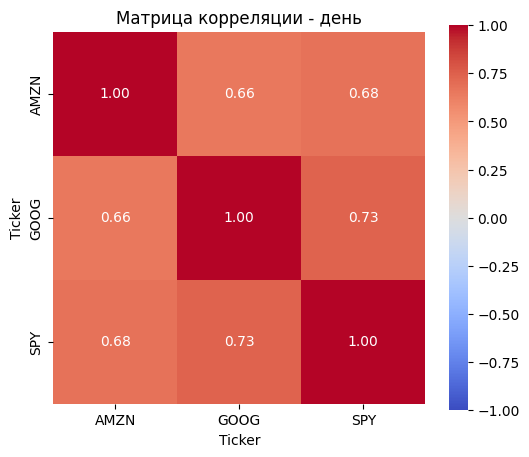

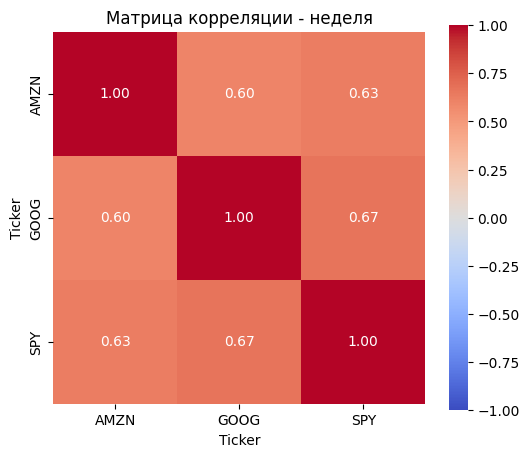

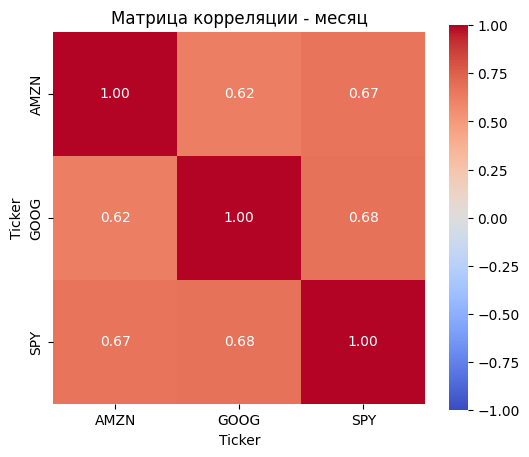

In [181]:
corrs = horizon_correlations(logret, horizons=['daily','weekly','monthly'])

def plot_corr_matrix(corr_df, title=''):
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', square=True)
    plt.title(title)
    plt.show()

for h, mat in corrs.items():
    plot_corr_matrix(mat, title=f'Матрица корреляции - {horizons_map[h]}')

### 8. Выводы
- Реализованная волатильность, рассчитанная скользящим окном, позволяет оценить фактический уровень рыночных изменений;


- При переходе от дневного к недельному и месячному горизонтам наблюдается снижение амплитуды и частоты колебаний волатильности.  
  Это связано с эффектом усреднения: на более крупных временных интервалах краткосрочные колебания доходностей частично компенсируются, и оценка волатильности становится более сглаженной. Таким образом, характер поведения волатильности меняется - от "шумного" к более устойчивому;


- Волатильность фондовых индексов существенно изменяется во времени, что хорошо описывается моделью GARCH(1,1). Использование GARCH-модели в нашем случае позволяет получить оценку ожидаемой волатильности для каждого горизонта,  что открывает возможность построения многоуровневых стратегий управления риском, где решения принимаются с учётом разного временного масштаба;


- Корреляция индексов SPY, GOOG, AMZN падает при переходе от дневного к месячному горизонту, что противоречит устоявшимся наблюдениям. Это можно объяснить тем, что GOOG и AMZN демонстрируют разную степень чувствительности к рыночным циклам и ставкам ФРС, тогда как SPY отражает усреднённую реакцию широкого рынка. Это также ослабляет корреляцию при переходе к более длинным горизонтам.